Detect and track developing DCCs in GOES-16 ABI data

In [1]:
import os
import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from scipy import ndimage as ndi
from scipy import stats
import matplotlib.pyplot as plt

In [37]:
from tobac_flow.dataloader import goes_dataloader
from tobac_flow.flow import create_flow
from tobac_flow.analysis import (
    find_object_lengths, remap_labels, labeled_comprehension, mask_labels
)
from tobac_flow.detection import get_curvature_filter, get_growth_rate
from tobac_flow.label import slice_labels
from tobac_flow.plotting import goes_figure

In [3]:
# Setup input args

hours = 4

start_date = datetime(2018, 6, 19, 17)
end_date = start_date + timedelta(hours=hours)

satellite = 16

x0 = 1300
x1 = 1600
y0 = 600
y1 = 900

t_offset = 3

save_dir = "../data/dcc_detect"
if not os.path.isdir(save_dir):
    try:
        os.makedirs(save_dir)
    except (FileExistsError, OSError):
        pass

save_name = 'detected_dccs_G%02d_S%s_E%s_X%04d_%04d_Y%04d_%04d.nc' % \
    (satellite, start_date.strftime('%Y%m%d_%H0000'), end_date.strftime('%Y%m%d_%H0000'),
     x0, x1, y0, y1)

save_path = os.path.join(save_dir, save_name)

print("Saving output to:", save_path)

goes_data_path = "../data/GOES16/"
if not os.path.isdir(goes_data_path):
    try:
        os.makedirs(goes_data_path)
    except (FileExistsError, OSError):
        pass


Saving output to: ../data/dcc_detect/detected_dccs_G16_S20180619_170000_E20180619_210000_X1300_1600_Y0600_0900.nc


In [4]:
# Load ABI data
io_kwargs = {'satellite':satellite,
             'product':'MCMIP',
             'view':'C',
             'mode':[3,4,6],
             'save_dir':goes_data_path,
             'replicate_path':True,
             'check_download':True,
             'n_attempts':1,
             'download_missing':True}

bt, wvd, swd, dataset = goes_dataloader(
    start_date, end_date, n_pad_files=t_offset+1, x0=x0, x1=x1, y0=y0, y1=y1, return_new_ds=True, **io_kwargs
)

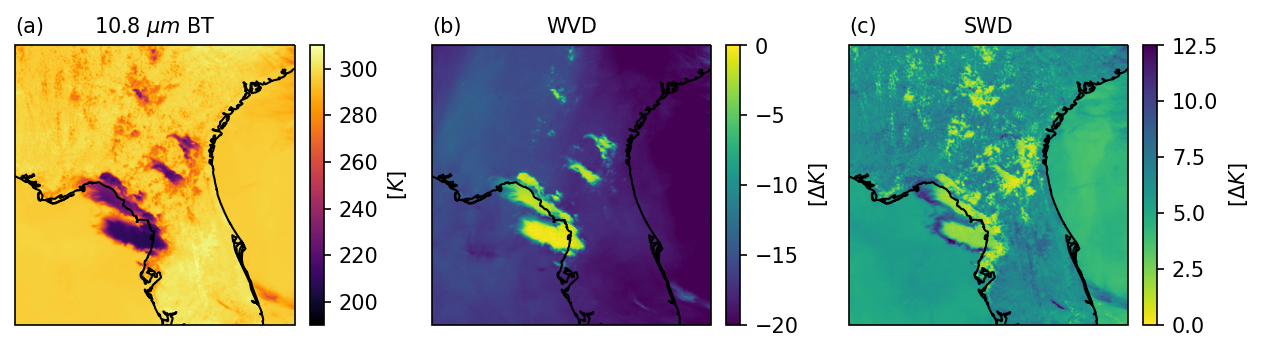

In [22]:
fig = goes_figure(dataset, dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[24], cmap="viridis", vmin=-20, vmax=0)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[24], cmap="viridis_r", vmin=0, vmax=12.5)
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

plt.subplots_adjust(hspace=0.1, bottom=0.1, top=0.85, left=0.075, right=0.95)

In [59]:
# Generate flow field
flow = create_flow(bt, model="DIS", vr_steps=1, smoothing_passes=1)

Text(0, 0.5, 'Distance along y axis [km]')

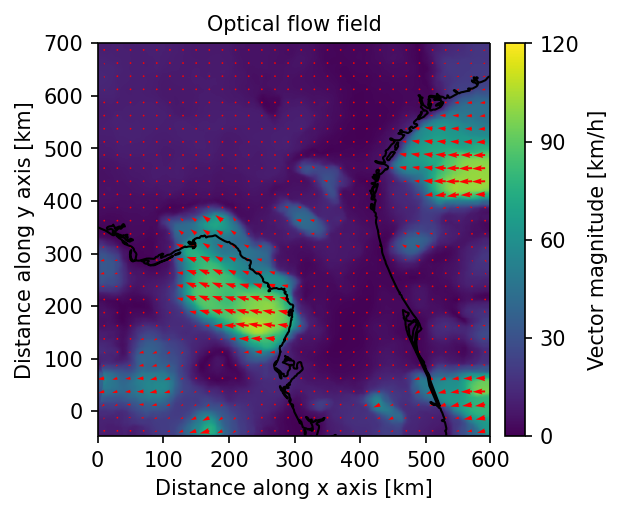

In [60]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

i=24
j=6

ax = fig.subplot(111)
ax.coastlines()
flow_magnitude = ((flow.forward_flow[i:i+j-1,...,0].mean(0)*2.5)**2 
                  + (flow.forward_flow[i:i+j-1,...,1].mean(0)*2)**2)**0.5 * 12
img = ax.imshow(flow_magnitude, vmin=0, vmax=120)
cbar = ax.colorbar(img)
cbar.set_label('Vector magnitude [km/h]', fontsize=10)
cbar.set_ticks([0,30,60,90,120])
q = ax.quiver(
    flow.forward_flow[i:i+j-1,...,0].mean(0), -flow.forward_flow[i:i+j-1,...,1].mean(0), 
    spacing=10, scale=100, width=0.005, color='r'
)
ax.set_title('Optical flow field', fontsize=10)
ax.set_xticks((bt.x*dataset.goes_imager_projection.perspective_point_height)[list(range(0,bt.x.size,50))+[-1]])
ax.set_xticklabels(np.arange(0,bt.x.size+1,50)*2)
ax.set_xlabel("Distance along x axis [km]", fontsize=10)
ax.set_yticks((bt.y*dataset.goes_imager_projection.perspective_point_height)[list(range(0,bt.y.size,40))])
ax.set_yticklabels((np.arange(0,bt.y.size+1,40)[::-1]*2.5).astype(int))
ax.set_ylabel("Distance along y axis [km]", fontsize=10)


In [61]:
# Calculate growth fields
wvd_growth = get_growth_rate(flow, wvd)
bt_growth = get_growth_rate(flow, bt)

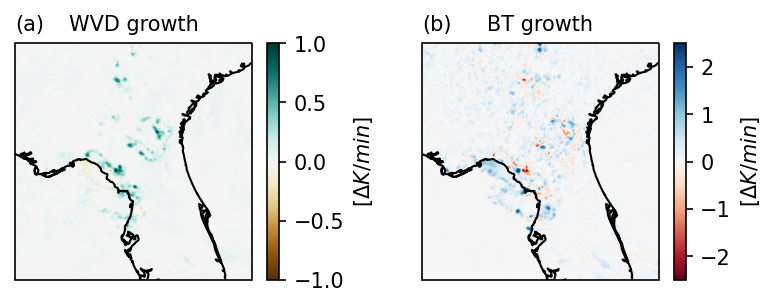

In [62]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(121)
ax1.coastlines()
im1 = ax1.imshow(wvd_growth[24], cmap="BrBG", vmax=1, vmin=-1)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$\Delta K/min$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('WVD growth', fontsize=10)

ax2 = fig.subplot(122)
ax2.coastlines()
im2 = ax2.imshow(bt_growth[24], cmap="RdBu", vmin=-2.5, vmax=2.5)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K/min$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('BT growth', fontsize=10)

plt.subplots_adjust(wspace=0.4)

In [65]:
# Calculate curvature filters and detect cores
wvd_curvature_filter = get_curvature_filter(wvd, direction="negative")
bt_curvature_filter = get_curvature_filter(bt, direction="positive")

wvd_threshold = 0.25
bt_threshold = 0.25

wvd_markers = np.logical_and(
    wvd_growth > wvd_threshold, wvd_curvature_filter
)
bt_markers =  np.logical_and(
    bt_growth  < -bt_threshold, bt_curvature_filter
)

s_struct = ndi.generate_binary_structure(3,1)
s_struct *= np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

combined_markers = ndi.binary_opening(
    np.logical_or(wvd_markers, bt_markers), structure=s_struct
)

print('WVD growth above threshold: area =', np.sum(wvd_markers))
print('BT growth above threshold: area =', np.sum(bt_markers))
print('Detected markers: area =', np.sum(combined_markers))

overlap = 0.5
subsegment_shrink = 0.

core_labels = flow.label(
    combined_markers, overlap=overlap, subsegment_shrink=subsegment_shrink
)

print("Initial core count:", np.max(core_labels))

# Filter labels by length and wvd growth threshold
core_label_lengths = find_object_lengths(core_labels)

print("Core labels meeting length threshold:", np.sum(core_label_lengths>t_offset))

core_label_wvd_mask = mask_labels(core_labels, wvd_growth > wvd_threshold)

print("Core labels meeting WVD growth threshold:", np.sum(core_label_wvd_mask))

combined_mask = np.logical_and(core_label_lengths>t_offset, core_label_wvd_mask)

core_labels = remap_labels(core_labels, combined_mask)

core_step_labels = slice_labels(core_labels)

mode = lambda x : stats.mode(x, keepdims=False)[0]
core_step_core_index = labeled_comprehension(
    core_labels, core_step_labels, mode, default=0
)

core_step_bt_mean = labeled_comprehension(
    bt, core_step_labels, np.nanmean, default=np.nan
)

core_step_t = labeled_comprehension(
    bt.t.data[:, np.newaxis, np.newaxis], core_step_labels, np.nanmin, default=0
)

def bt_diff_func(step_bt, pos):
    step_t = core_step_t[pos]
    args = np.argsort(step_t)

    step_bt = step_bt[args]
    step_t = step_t[args]
    
    step_bt_diff = (
        (step_bt[:-t_offset] - step_bt[t_offset:])
         / ((step_t[t_offset:] - step_t[:-t_offset]).astype("timedelta64[s]").astype("int")/60)
    )

    return np.nanmax(step_bt_diff)

core_bt_diff_mean = labeled_comprehension(
    core_step_bt_mean, core_step_core_index, bt_diff_func, default=0, pass_positions=True
)

wh_valid_core = core_bt_diff_mean>=0.5

core_labels = remap_labels(core_labels, wh_valid_core)

print('Final detected core count: n =', core_labels.max())


WVD growth above threshold: area = 19484
BT growth above threshold: area = 21201
Detected markers: area = 18623
Initial core count: 367
Core labels meeting length threshold: 80
Core labels meeting WVD growth threshold: 291
Final detected core count: n = 68


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

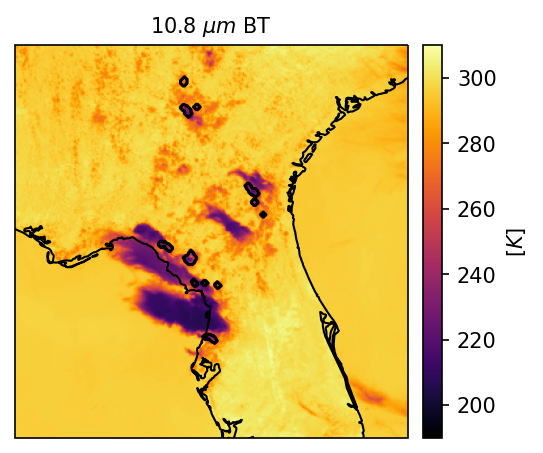

In [66]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.contour(core_labels[24], [0.5], colors=["k"])
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)


In [69]:
# Detect anvil regions
upper_threshold = -5
lower_threshold = -15
erode_distance = 2

field = (wvd-swd).data
field = np.maximum(np.minimum(field, upper_threshold), lower_threshold)

structure = ndi.generate_binary_structure(3,1)
s_struct = structure * np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

markers = ndi.binary_erosion(field>=upper_threshold, structure=s_struct)
markers = np.logical_and(markers, core_labels!=0)
mask = ndi.binary_erosion(
    field<=lower_threshold, structure=np.ones([3,3,3]),
    iterations=erode_distance, border_value=1
)

edges = flow.sobel(field, direction='uphill', method='linear')


Text(0.5, 1.0, 'Edges')

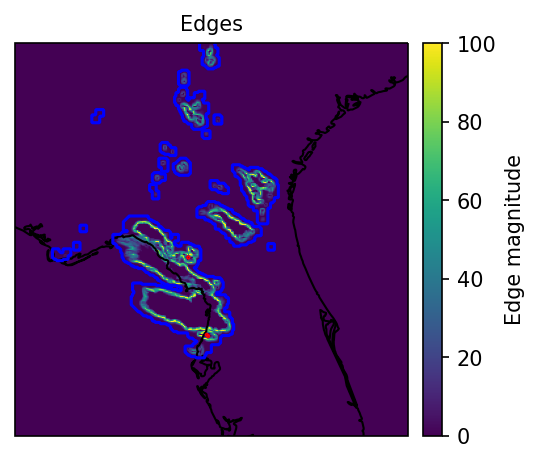

In [70]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(edges[24], cmap="viridis", vmin=0, vmax=100)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Edge magnitude', fontsize=10)
ax1.contour(markers[24], [0.5], colors=["r"])
ax1.contour(mask[24], [0.5], colors=["b"])
ax1.set_title('Edges', fontsize=10)


In [71]:
watershed = flow.watershed(edges, markers, mask=mask, structure=structure)

thick_anvil_labels = flow.label(
    ndi.binary_opening(watershed, structure=s_struct), overlap=overlap, subsegment_shrink=subsegment_shrink
)

print('Initial detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Initial detected thick anvils: n =', thick_anvil_labels.max(), flush=True)

thick_anvil_label_lengths = find_object_lengths(thick_anvil_labels)
thick_anvil_label_threshold = mask_labels(thick_anvil_labels, markers)

thick_anvil_labels = remap_labels(
    thick_anvil_labels,
    np.logical_and(thick_anvil_label_lengths>t_offset, thick_anvil_label_threshold)
)

print('Final detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Final detected thick anvils: n =', thick_anvil_labels.max(), flush=True)


Initial detected thick anvils: area = 242760
Initial detected thick anvils: n = 9
Final detected thick anvils: area = 242725
Final detected thick anvils: n = 7


In [77]:
upper_threshold = 0
lower_threshold = -10

markers = thick_anvil_labels
markers *= ndi.binary_erosion(markers, structure=s_struct).astype(int)

field = (wvd+swd).data
field = np.maximum(np.minimum(field, upper_threshold), lower_threshold)
field[markers!=0] = upper_threshold

mask = ndi.binary_erosion(
    field<=lower_threshold, structure=np.ones([3,3,3]),
    iterations=erode_distance, border_value=1
)

edges = flow.sobel(field, direction='uphill', method='linear')

thin_anvil_labels = flow.watershed(edges, markers, mask=mask,
                                   structure=structure)

thin_anvil_labels *= ndi.binary_opening(thin_anvil_labels, structure=s_struct).astype(int)

print('Detected thin anvils: area =', np.sum(thin_anvil_labels!=0), flush=True)


Detected thin anvils: area = 416101


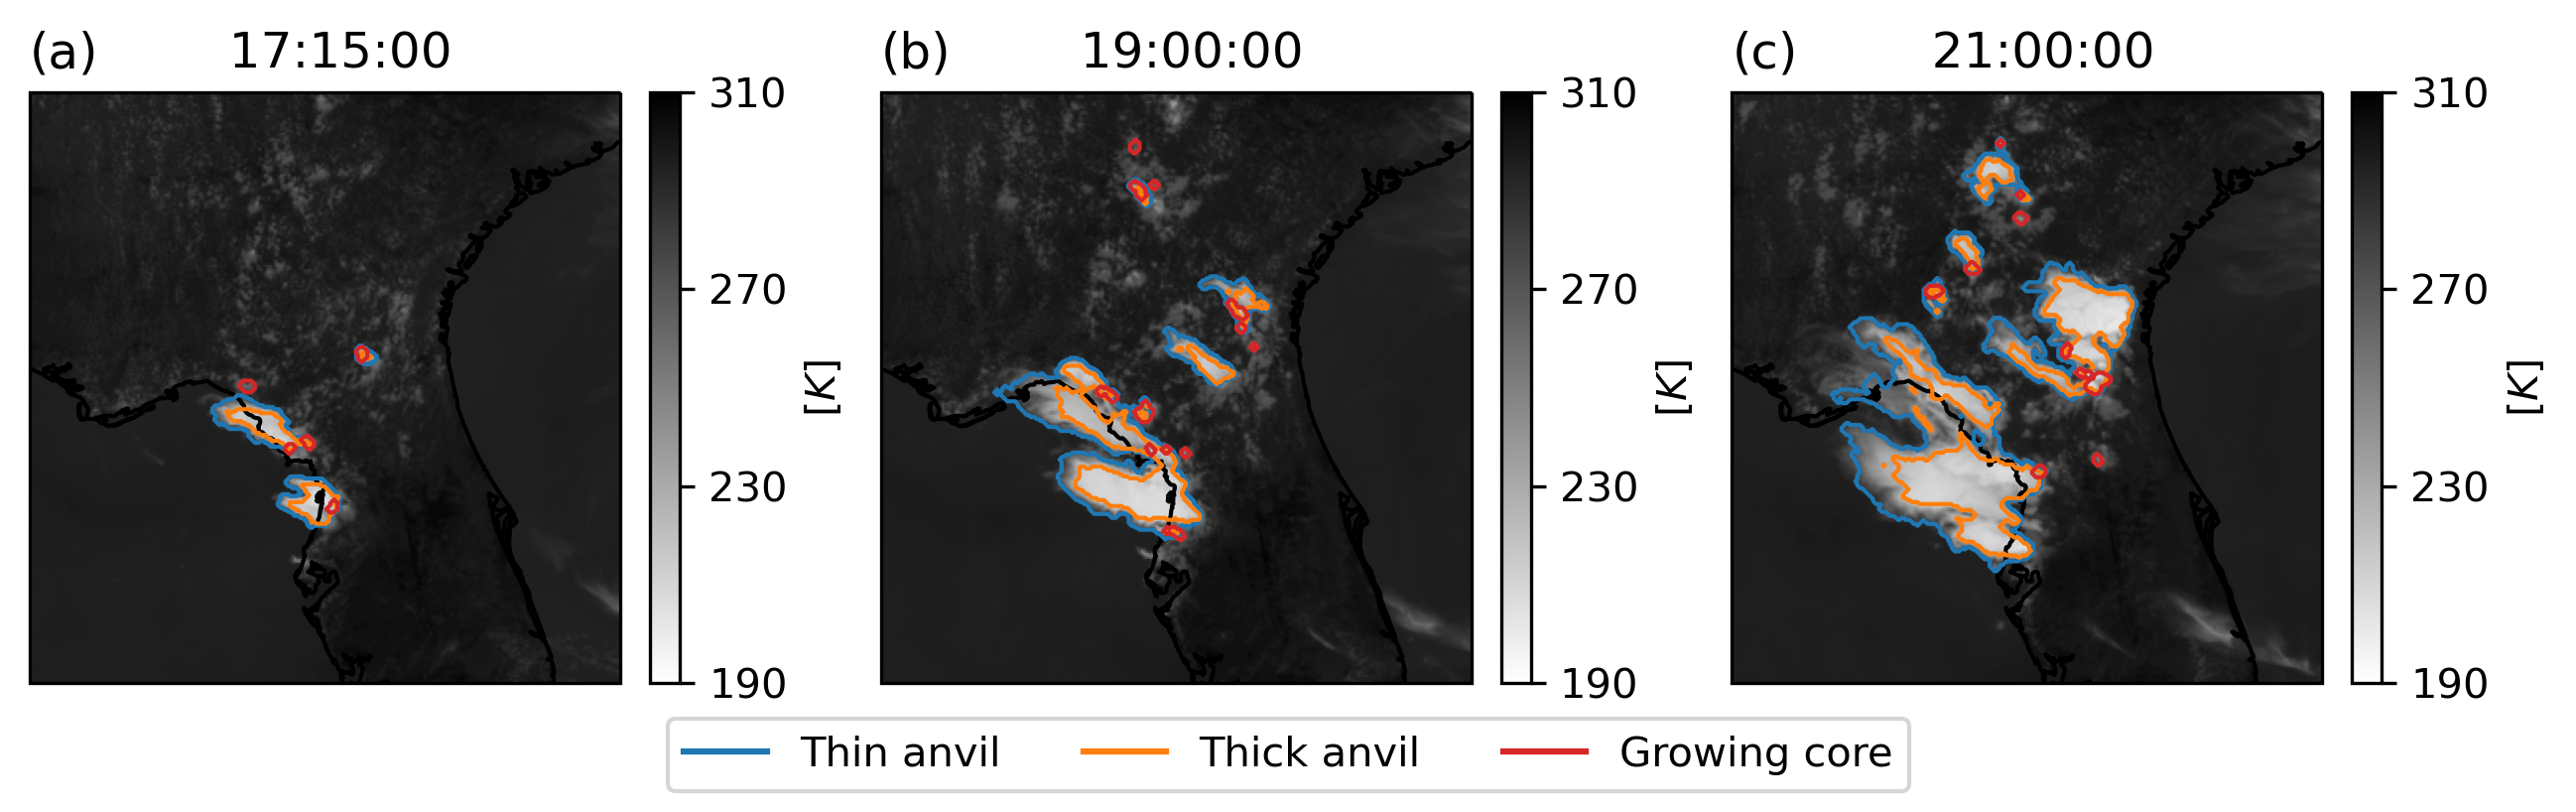

In [78]:
fig = goes_figure(dataset, dpi=300, figsize=(9,3))

i1=12
ax1 = fig.subplot(131)
ax1.coastlines()
img = ax1.imshow(bt[i1], vmin=190, vmax=310, cmap='binary')
cbar = ax1.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax1.set_title('(a)', loc='left')
ax1.set_title('  17:15:00')

ax1.contour(thin_anvil_labels[i1], [0.5], colors=['C00'], linewidths=[1])
ax1.contour(thick_anvil_labels[i1], [0.5], colors=['C01'], linewidths=[1])
ax1.contour(core_labels[i1], [0.5], colors=['C03'], linewidths=[1])

i2=24
ax2 = fig.subplot(132)
ax2.coastlines()
img = ax2.imshow(bt[i2], vmin=190, vmax=310, cmap='binary')
cbar = ax2.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax2.set_title('(b)', loc='left')
ax2.set_title('  19:00:00')

ax2.contour(thin_anvil_labels[i2], [0.5], colors=['C00'], linewidths=[1])
ax2.contour(thick_anvil_labels[i2], [0.5], colors=['C01'], linewidths=[1])
ax2.contour(core_labels[i2], [0.5], colors=['C03'], linewidths=[1])

i3=36
ax3 = fig.subplot(133)
ax3.coastlines()
img = ax3.imshow(bt[i3], vmin=190, vmax=310, cmap='binary')
cbar = ax3.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax3.set_title('(c)', loc='left')
ax3.set_title('  21:00:00')

ax3.contour(thin_anvil_labels[i3], [0.5], colors=['C00'], linewidths=[1])
ax3.contour(thick_anvil_labels[i3], [0.5], colors=['C01'], linewidths=[1])
ax3.contour(core_labels[i3], [0.5], colors=['C03'], linewidths=[1])

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
           ['Thin anvil', 'Thick anvil', 'Growing core'], loc='lower center', ncol=3)

plt.subplots_adjust(bottom=0.05, hspace=0.1, left=0)